# Wavelet Based Denoising using SureShrink
### Setting
#### 1. Task
Suppose there are $n$ noisy samples of a function $f$:
$$
y_i = f(t_i) + \sigma \epsilon_i, i \in \{1, \ldots, n \}
$$
where $\epsilon_i$ are *iid* $N(0, 1)$, but the noise level $\sigma$ is unknown.

#### 2. Loss Function
$\mathcal{L}(f, \hat{f}) = \vert \vert f - \hat{f} \vert \vert_2 $.

#### 3. Statistical Goal
In this wask we would like to minimize the squared error, e.g. $$\hat{f} = \text{arg}\min_f \mathcal{L}(f, \hat{f})$$ where $\mathcal{L}$, our loss function, is the standard $l_2$ norm. 

Note that to create a 'nice' theory, one will usually assume that $\hat{f}$ belongs to come function class $\mathcal{F}$ (e.g. $\hat{f} \in L_2(\mathbb{R})$), and then will find the best function $\hat{f}$ constrained to the fact that $\hat{f} \in \mathcal{F}$.

This is nice theoretically but bad practically, and it is rarely an assumption that corresponds with a real situation. E.g., we have no idea what function class $\mathcal{F}$ our eeg data belongs to.

So, this algorithm assumes that $\mathcal{F}$ is a member of a scale of function classes. E.g., the $L_2-$Sobolev scale. A description of this space is outside the scope of this .md, but informally, it allows us to work with no knowledge of things like the degree of differentiability of the function we are working with, or on values of derivatives.

#### 4. Computational Goal
Worst case performance for the discrete wavelet transform takes $O(N)$ time where $N$ is the number of samples. The worst case performance for the SureShrink algorithm is $O(N \log N)$.

#### 5. Desirata
It appears that there is no SureShrink algorithm implemented in python. There are however many wavelet libraries that may be useful.

### Approach
I will first state some theoretical facts that help motivate the algorithm.
* The discrete wavelet transform is an orthogonal transformation. This has a statistical consequence: white noise in the signal will be translated into white noise in the wavelet coefficients. More precisely, if $\mathcal{W}$ is the wavelet transform, then:
$$
\mathcal{W}(f + \epsilon) = w + k\epsilon
$$, meaning that the coefficients given by the wavelet transform are the true coefficients with added gaussian noise.

* The $\mathcal{W}$ takes estimators in one domain to estimators in the other domain with isometry of risks. E.g., if $\hat{f}$ is an estimator for $f$ the signal and $\hat{w}$ is an estimator for $w$ the coefficient vector, we have that the losses obey Parseval's relation, e.g.
$$
\vert \vert \hat{w} - w \vert \vert_2 = \vert \vert \hat{f} - f \vert \vert_2
$$

* When a noiseless signal is transformed using $\mathcal{W}$, most of the coefficients are effectively zero (very small). Thus, the task of recovering $f$ can be reduced to the task of finding (relatively few) coefficients in $w$ which are significantly non-zero against a Gaussian white noise background (e.g., their magnitude is with low probability due to the gaussian noise).

* Suppose you have $x = [x_1, \ldots, x_n]^T$ each *iid* $N(\mu_i, 1)$ for respective $i$. We would like to estimate the mean vector $\mu = [\mu_1, \ldots, \mu_n]^T$ using $x$. We say that $\hat{\mu}(x) = x + g(x)$ where $g$ is 'weakly differentiable'. Stein's unbiased risk estimate is $SURE(\hat{\mu}) = E_\mu \vert \vert \mu - \hat{\mu} \vert \vert_2^2 = n + E_\mu \{\vert \vert g(x) \vert \vert_2^2 + 2 \nabla  g(x) \}$, which stein proved is unbiased. We can now define a soft thresholding rule:
$$\delta_\lambda^S(d_{jk}) = \begin{cases} 
      0 & \vert d_{jk} \leq \lambda \\
      d_{jk} - \lambda & d_{jk} > \lambda \\
      d_{jk} + \lambda & d_{jk} < -\lambda
  \end{cases}$$
 
 
This lets us use $\delta_\lambda^S(x) = x + g(x)$ and plug into the SURE estimator to get:

$$
SURE(\lambda, x) = n + \sum_{i=1}^n(\min(\vert x_i \vert, \lambda))^2 - 2 \vert \{i : \vert x_i\vert \leq \lambda\} \vert
$$

Now we can find the best threshold
$$
\lambda^* = \text{arg}\min_{0 \leq \lambda \leq \sqrt{2 \log n}}SURE(\lambda, x)
$$

Where we stop at $\sqrt{2 \log n}$ because it has been shown 
$$
Pr \{ \max_{i \leq i \leq n} \vert x_i \vert > \sqrt{2 \log{n}}\}
$$

$$
SURE(\lambda, x) = n + \sum_{i=1}^n(\min(\vert x_i \vert, \lambda))^2 - 2 \vert \{i : \vert x_i\vert \leq \lambda\} \vert
$$
#### Pseudocode
Input:
  * *`F`*: A function sampled at time point, $\{ x_i \}_{i=1}^n$ evenly spaced throughout an interval of length $2^J$ for some J, $(f(x_i))_{i=1}^n$
  * `wave` - A wavelet family

Return:
  * $\hat{F}$ a denoised $F$.
  
DENOISE_SURE_SHRINK( `F`, `wave`):
1. Calculate the discrete wavelet transform with respect to the chosen mother wavelet $\vec{c} = \mathcal{W}_{wave}F$.
2. Calculate $\lambda^* = \text{arg}\min_\lambda SURE(\lambda, \vec{c})$
3. For each $c_i \in F$, let $c_i = \delta_{\lambda^*}^S(c_i)$
4. Calculate the inverse discrete wavelet transform with respect to the chosen mother wavelet $\hat{F} = \mathcal{W}_{wave}^{-1}\vec{c}$

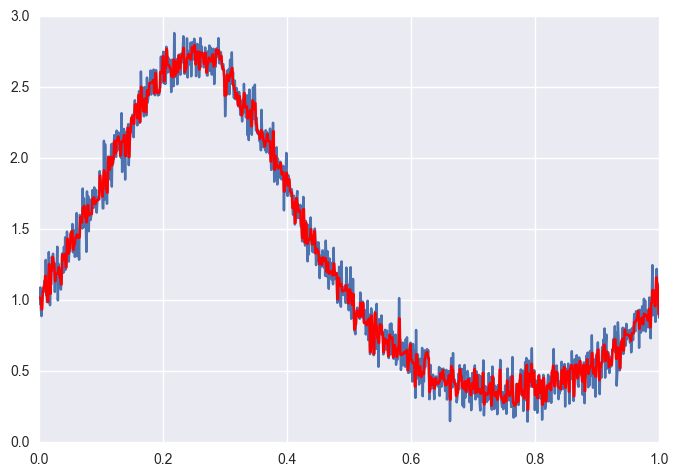

In [102]:
import pywt
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
def SURE(t, X):
    x_gt = np.abs(X) > t
    y = np.ones(X.shape) * t
    y[x_gt] = np.abs(X)[x_gt]
    S = np.sum(np.square(y))
    n = X.shape[0]
    card = np.sum(np.logical_not(x_gt))
    return n + S -2 * card
def SURE_SHRINK(X):
    L = []
    for x in X:
        L.append(SURE(x, X))
    min_thresh = X[np.argmin(L)]
    for i in range(X.shape[0]):
        if np.abs(X[i]) <= min_thresh:
            X[i] = 0
        elif X[i] > min_thresh:
            X[i] = X[i] - min_thresh
        elif X[i] < -min_thresh:
            X[i] = X[i] + min_thresh
    return X
def SURE_SHRINK_DENOISE(f, wavelet):
    (cA, cD) = pywt.dwt(f, 'db1')
    cD = SURE_SHRINK(cD)
    f_prime = pywt.idwt(cA, cD, 'db1')
    return f_prime
X = np.linspace(0, 1, 1024)
noise = np.random.normal(0, .1, X.shape)
f = np.exp(np.sin(2 * np.pi * X)) + noise
f_denoised = SURE_SHRINK_DENOISE(f, 'db1')
f_denoised = SURE_SHRINK_DENOISE(f_denoised, 'db1')
plt.plot(X, f)
plt.plot(X, f_denoised, 'r')
plt.show()
plt.show()

### results
#### why would it work well?
Due to the theoretical properties of the wavelet transform (which we will take as true for purposes of being simple in this notebook), this denoising technique intuitively should do quite well because the wavelet transform sets most coefficients to near 0 so that it is sparse, and the coefficients returned from the wavelet transform have the same amount of noise (up to a factor) of the original signal. This means that if we were to zero out all the coefficients which appear to be small enough that they are just gaussian noise (and by shrinking all the larger coefficients by the max amount they were perturbed by the gaussian noise) the signal resulting from an inverse transformation on the resulting coefficients should be closer to the original signal, sans the noise.

Of course, the big assumption in the beginning is that the noise added is additive gaussian white noise. The paper from which this algorithm was created says that many real life situations can be thought of like this, but we really do not know whether our EEG data even follows these assumptions. Therefore, we should be wary of the results, and we should also study the effect of this algorithm on non-additive and non-gaussian noise so that we understand how poorly it can perform without the assumptions being met.

#### supporting geometric intuition

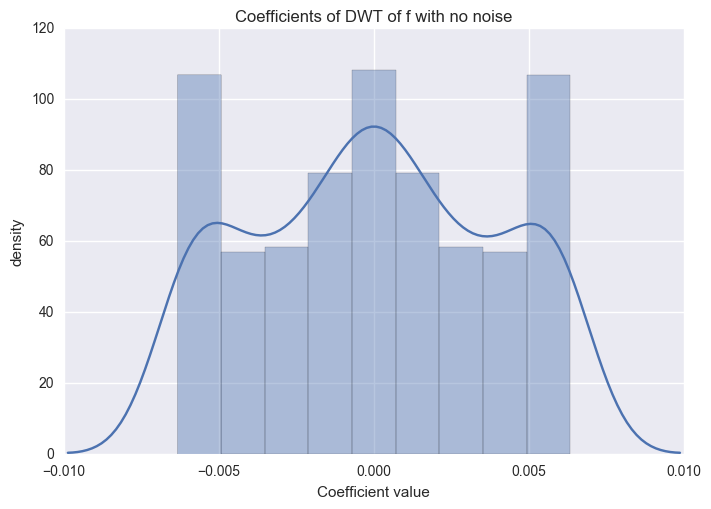

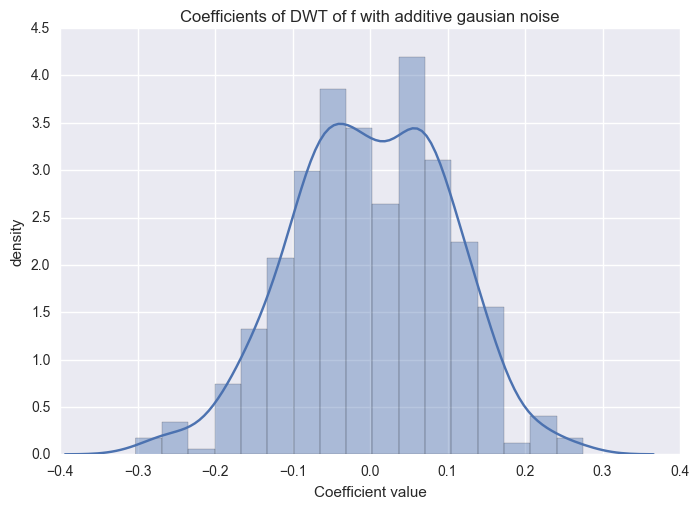

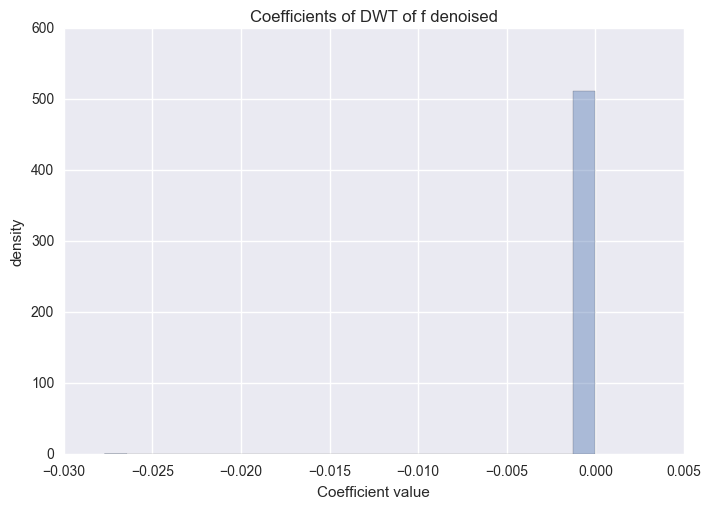

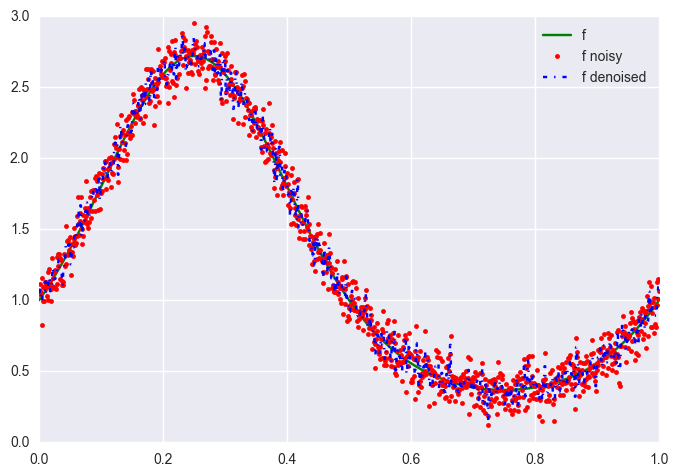

In [131]:
X = np.linspace(0, 1, 1024)
noise = np.random.normal(0, .1, X.shape)
f = np.exp(np.sin(2 * np.pi * X))
(cA, cD) = pywt.dwt(f, 'db1')
sns.distplot(cD)
plt.title('Coefficients of DWT of f with no noise')
plt.xlabel('Coefficient value')
plt.ylabel('density')
plt.show()
(cA, cD) = pywt.dwt(f + noise, 'db1')
sns.distplot(cD)
plt.title('Coefficients of DWT of f with additive gausian noise')
plt.xlabel('Coefficient value')
plt.ylabel('density')
plt.show()
f_denoised = SURE_SHRINK_DENOISE(f + noise, 'db1')
(cA, cD) = pywt.dwt(f_denoised, 'db1')
sns.distplot(cD, kde=False)
plt.title('Coefficients of DWT of f denoised')
plt.xlabel('Coefficient value')
plt.ylabel('density')
plt.show()
plt.plot(X, f, 'g-', label='f')
plt.plot(X, f + noise, 'r.', label='f noisy')
plt.plot(X, f_denoised, 'b-.', label = 'f denoised')
plt.legend()
plt.show()

In [148]:
def test(fun):
    noises = 1. / np.arange(1, 30)
    results = []
    for noise in noises:
        noise = np.random.normal(0, noise, X.shape)
        f = fun(X)
        f_denoised = SURE_SHRINK_DENOISE(f + noise, 'db1')
        orig_norm = np.linalg.norm(f - (f + noise)) / f.shape[0]
        new_norm = np.linalg.norm(f - f_denoised) / f.shape[0]
        results.append((orig_norm, new_norm))
    orig, new = zip(*results)
    plt.plot(noises, orig, label = 'Norm Original - Noisy')
    plt.plot(noises, new, label = 'Norm Original - Denoised')
    plt.legend()
    plt.show()

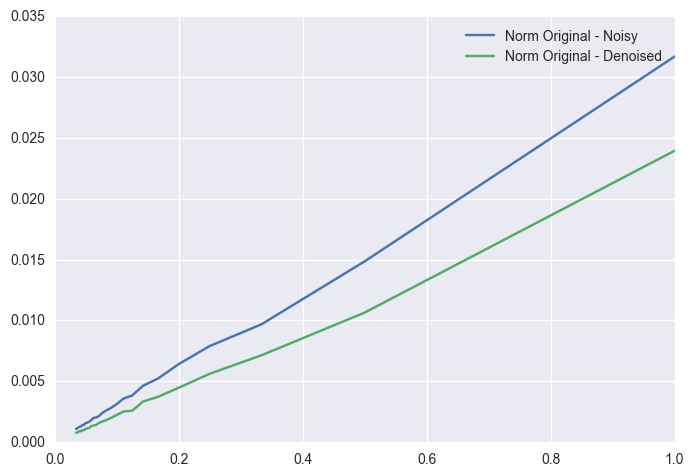

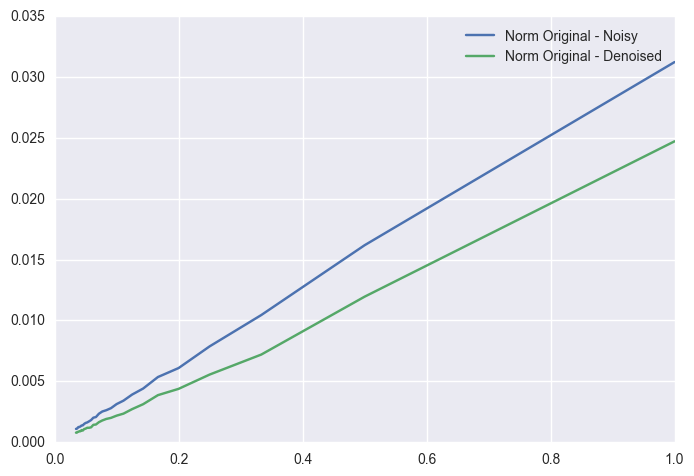

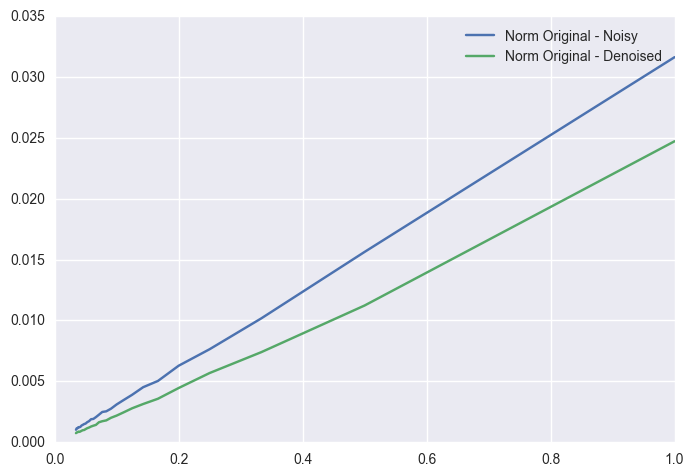

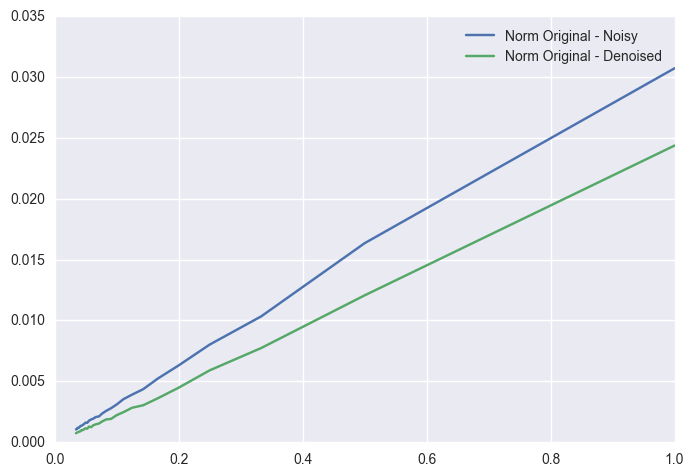

In [158]:
def f_1(X):
    return np.sin(2 * np.pi * X)
def f_2(X):
    return np.abs(X)
def f_3(X):
    return np.exp(f_1(X))
def f_4(X):
    return f_1(np.square(X))
test(f_1)
test(f_2)
test(f_3)
test(f_4)